# Problem Statement:

Persistency of drug as per the physician prescription

# ML Problem: Classification

# Target Variable: Persistency_Flag

Feature Description:

Unique Row Id	
Patient ID	
Persistency_Flag	
Demographics:
 - Age	
 - Race	
 - Region
 - Ethnicity	
 - Gender	
 - IDN Indicator	---Flag indicating patients mapped to IDN

Provider Attributes	

 - NTM - Physician Specialty -----	Specialty of the HCP that prescribed the NTM Rx
 - NTM - T-Score 	
 - T Score       ------        at the time of the NTM Rx (within 2 years prior from rxdate)
 - Change in T Score 	------ before starting with any therapy and after receiving therapy  
                         (Worsened, Remained Same, Improved, Unknown)
 - NTM Risk Segment	---- at the time of the NTM Rx (within 2 years days prior from rxdate)
 - Change in Risk Segment	before starting with any therapy and after receiving therapy
                         (Worsened, Remained Same, Improved, Unknown)
 - NTM Multiple Risk Factors -----	if  patient falls under multiple risk category (having more than 1 risk) at the time of the NTM Rx (within 365 days prior from rxdate)

Clinical Factors:

 - NTM - Dexa Scan Frequency	----Number of DEXA scans taken prior to the first NTM Rx date (within 365 days prior from rxdate)
 - NTM - Dexa Scan Recency	 ----   the presence of Dexa Scan before the NTM Rx (within 2 years prior from rxdate or between their first Rx and Switched Rx; whichever is smaller and applicable)
 - Dexa During Therapy	  -----      if the patient had a Dexa Scan during their first continuous therapy
 - NTM - Fragility Fracture Recency	if the patient had a recent fragility fracture (within 365 days prior from rxdate)
 - Fragility Fracture During Therapy ----	if the patient had fragility fracture  during their first continuous therapy
 - NTM - Glucocorticoid Recency	  usage of Glucocorticoids (>=7.5mg strength) in the one year look-back from the first NTM Rx
 - Glucocorticoid Usage During Therapy	---if the patient had a Glucocorticoid usage during the first continuous therapy
 - NTM - Injectable Experience	-----any injectable drug usage in the recent 12 months before the NTM OP Rx
 - NTM - Risk Factors	------- Risk Factors that the patient is falling into. 
                                for chronic Risk Factors complete lookback to be applied 
                                for non-chronic Risk Factors, one year lookback from the date of first OP Rx 
 
 
Disease/Treatment Factor

 - NTM - Comorbidity 	-----Comorbidities are divided into two main categories based on the ICD codes
                               Acute 
                               Chronic --- For chronic disease we are taking complete look back from the first Rx date of NTM therapy and for acute diseases, time period  before the NTM OP Rx with one year lookback has been applied
                              
 - NTM - Concomitancy	Concomitant drugs recorded prior to starting with a therapy(within 365 days prior from first rxdate)
 - Adherence	Adherence for the therapies

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import preprocessing
import copy
from sklearn.model_selection import train_test_split

In [3]:
!/usr/bin/env python -W ignore::DeprecationWarning

The system cannot find the path specified.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
ds = pd.read_excel('Healthcare_dataset_.xlsx', 'Dataset', index_col=None)
ds.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


In [26]:
# import lux

In [14]:
# ds

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [15]:
# ds.save_as_html()

Saved HTML to export.html


In [196]:
ds.shape

(3424, 69)

In [197]:
len(ds.columns)

69

In [198]:
ds.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Com

# Empty values

In [199]:
found = False
for column in ds.columns:
    if ds[column].isnull().sum() != 0:
        found = True
        print('Column',column, 'has null values')
if found  == False:
    print('The dataset does not contain empty values')

The dataset does not contain empty values


# Duplications

In [200]:
ds[ds.duplicated(['Ptid'], keep=False)]

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks


No duplications

# Replace all N -> 0 and Y -> 1

In [201]:
ds = ds.replace(['N','Y'],[0,1])

# Columns that contain only one category or outliers

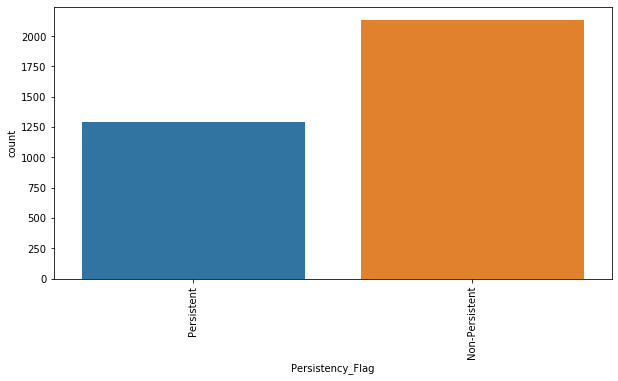

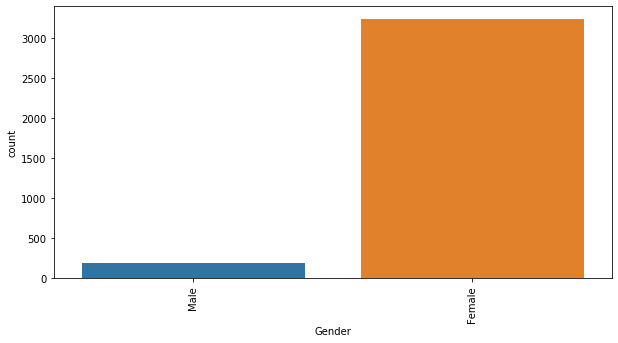

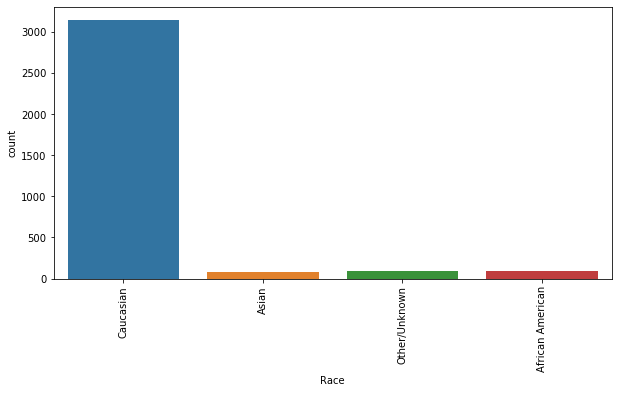

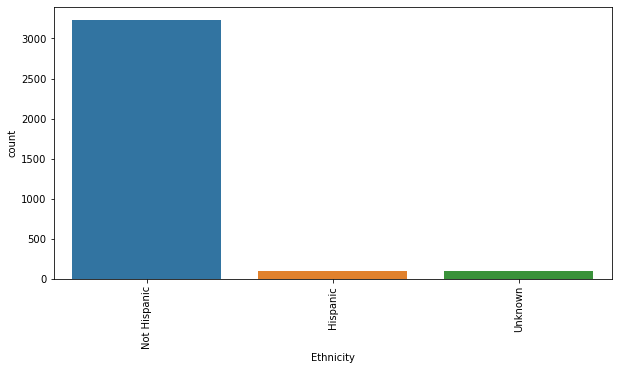

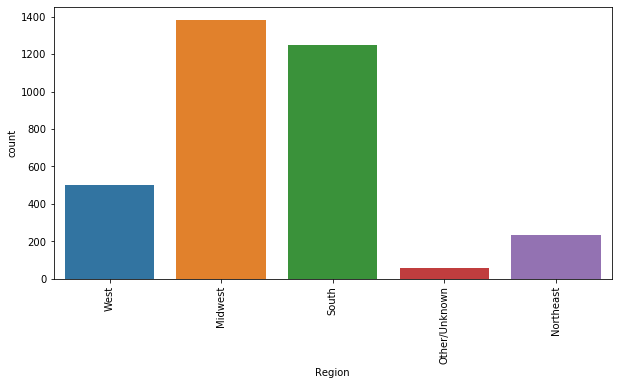

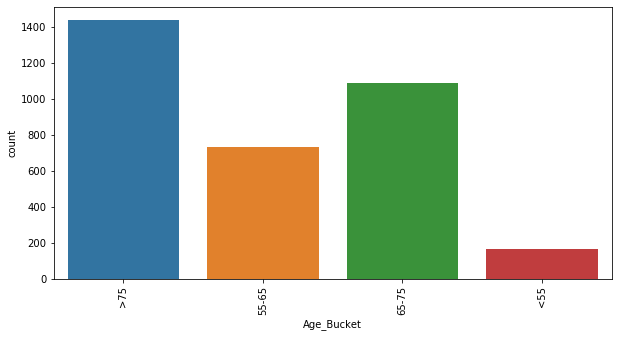

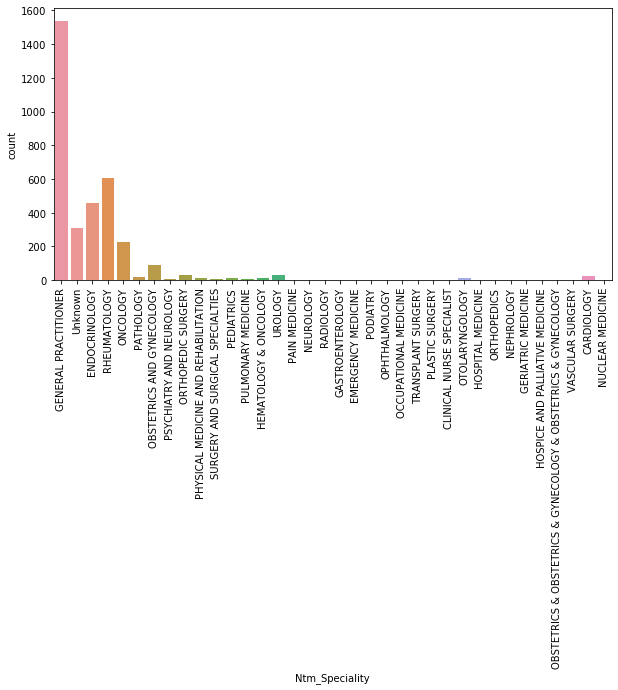

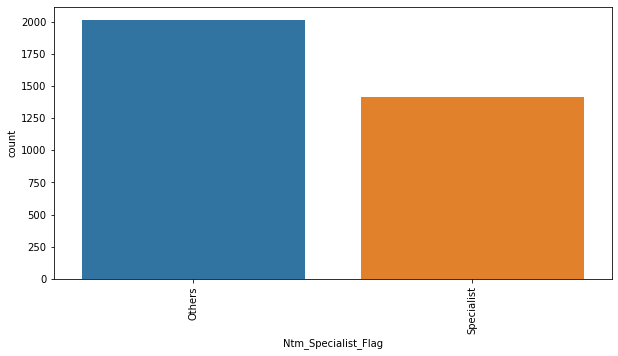

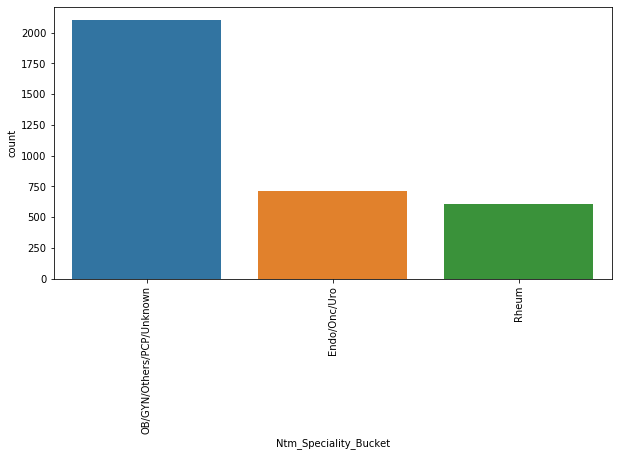

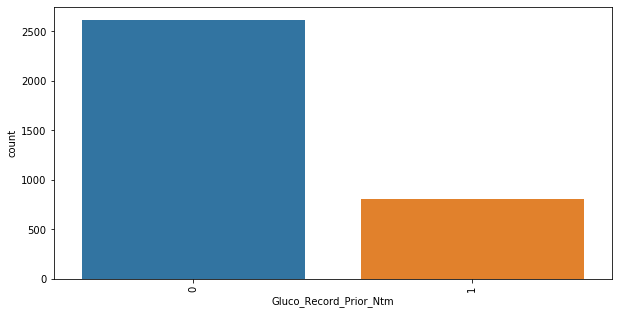

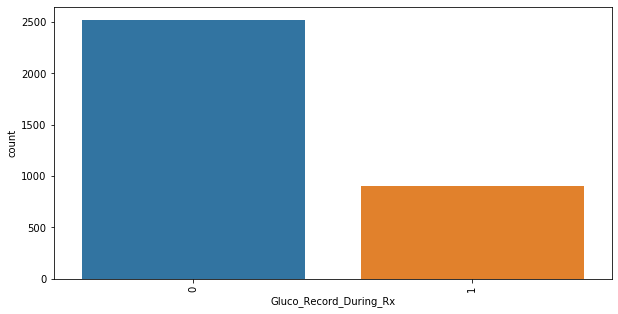

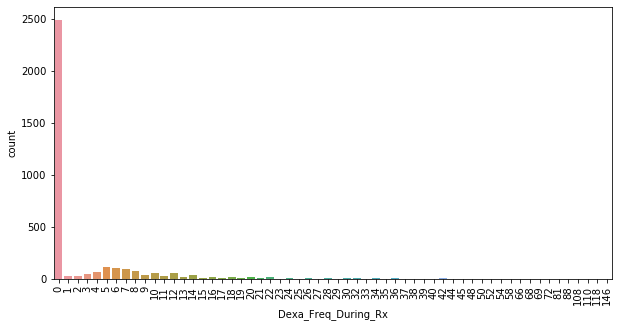

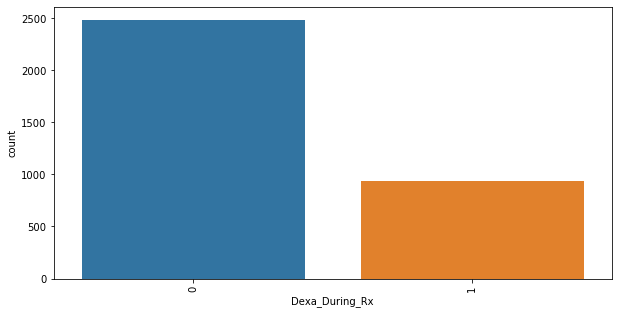

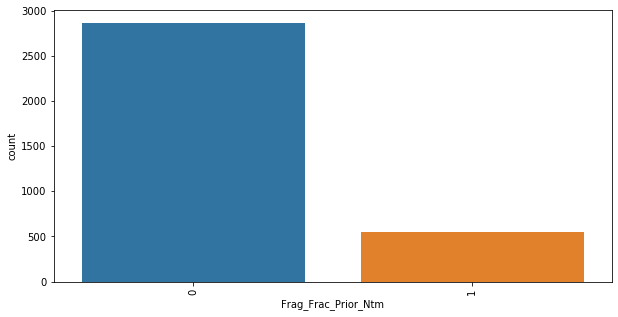

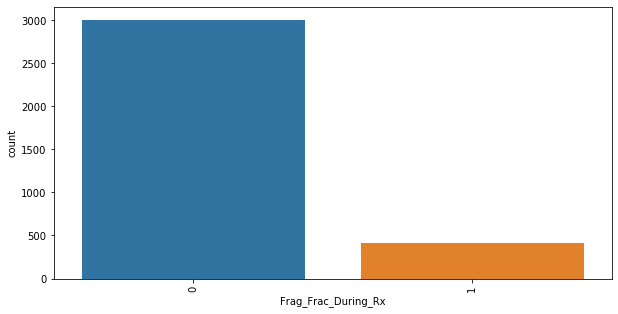

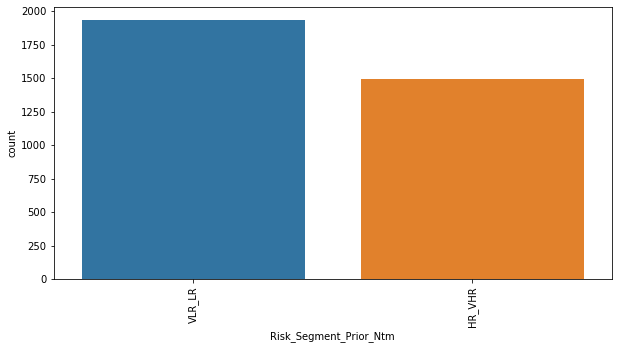

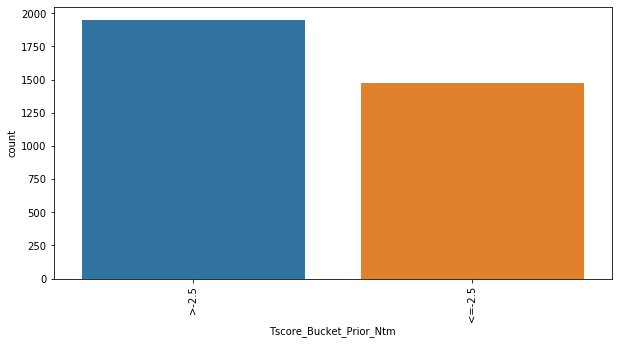

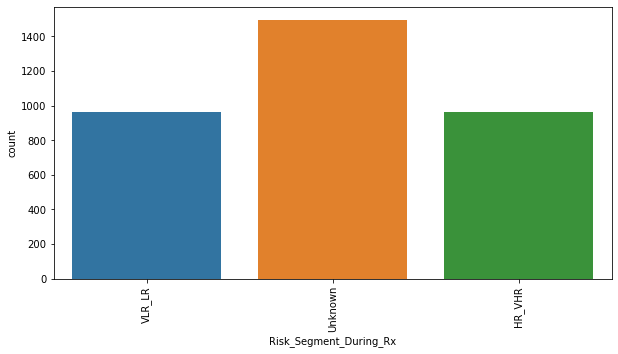

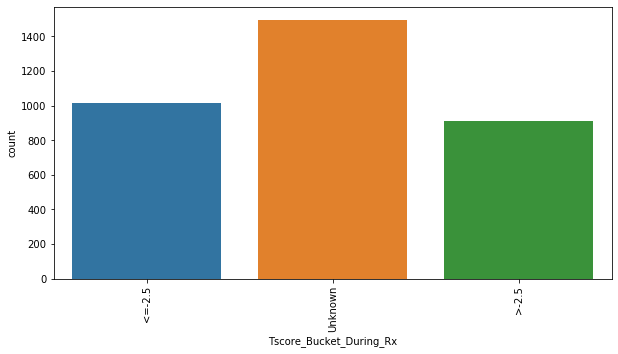

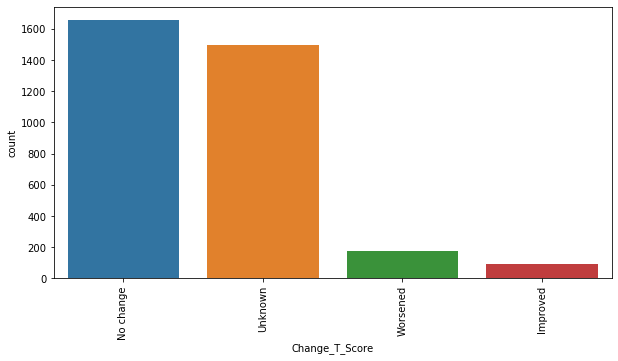

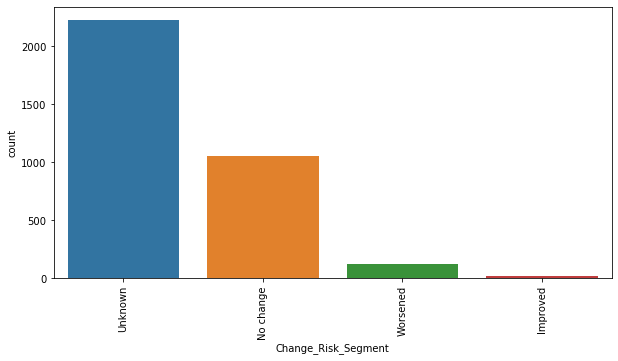

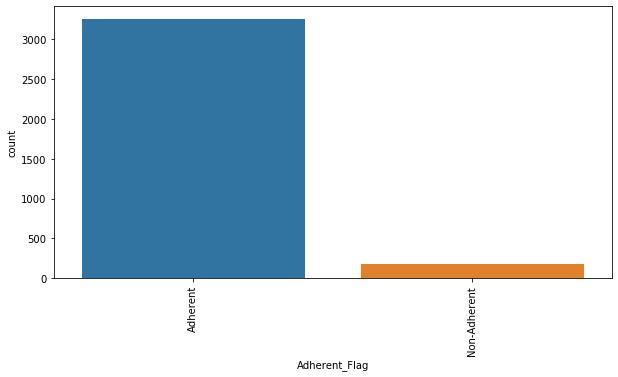

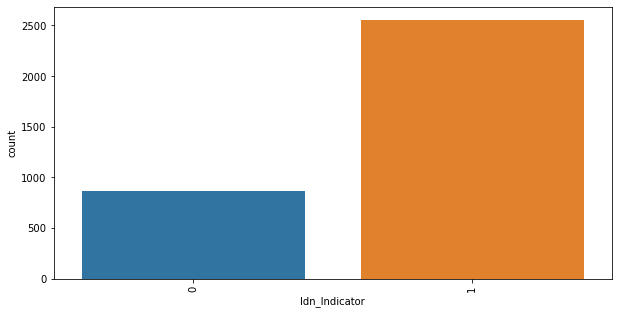

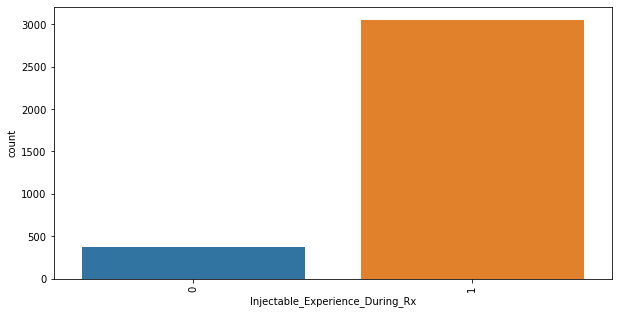

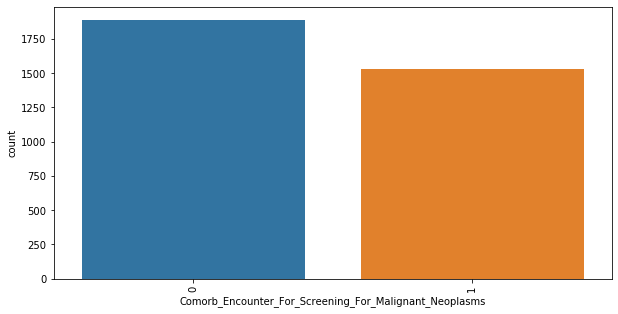

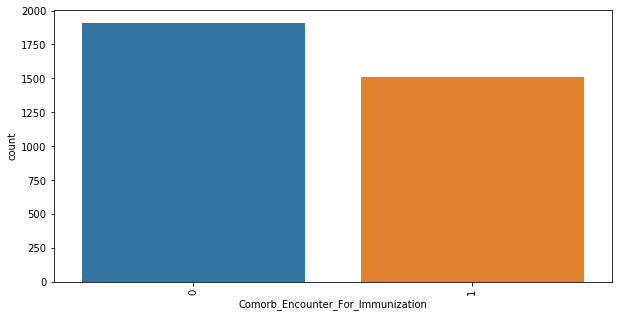

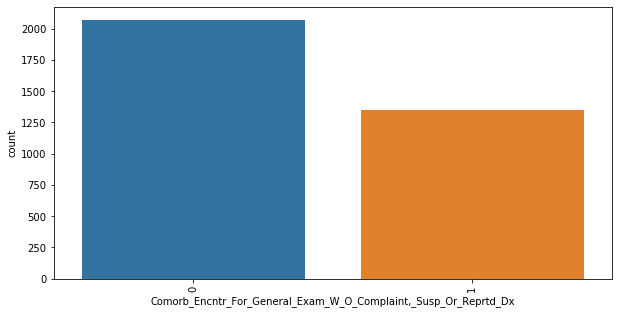

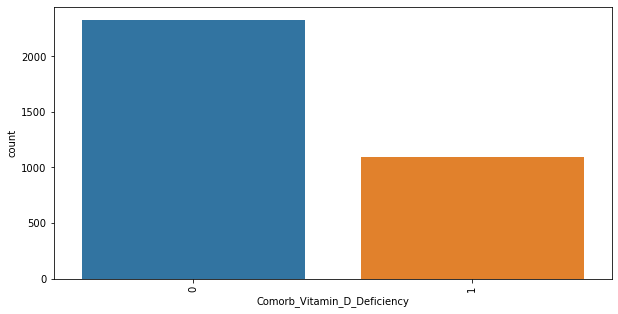

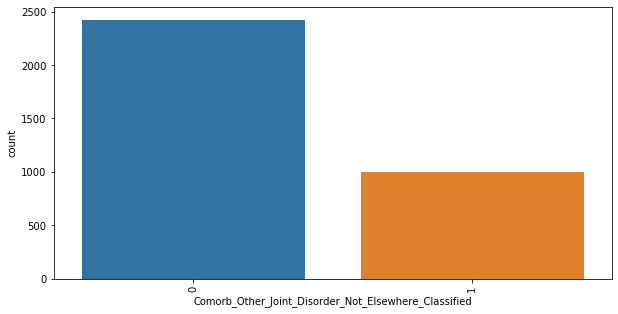

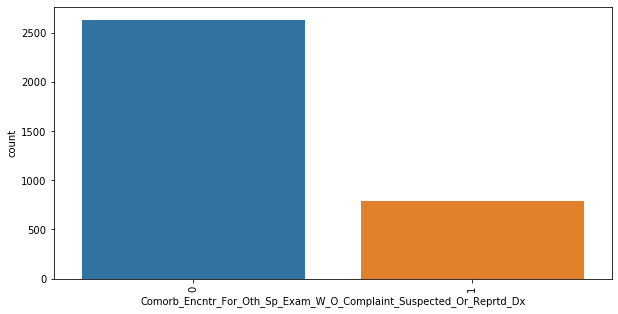

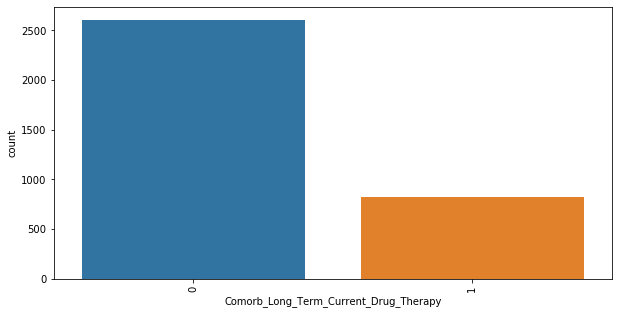

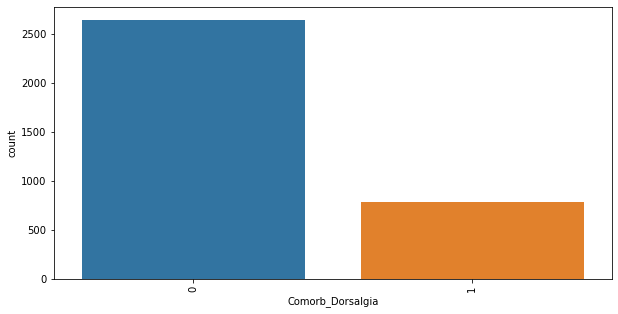

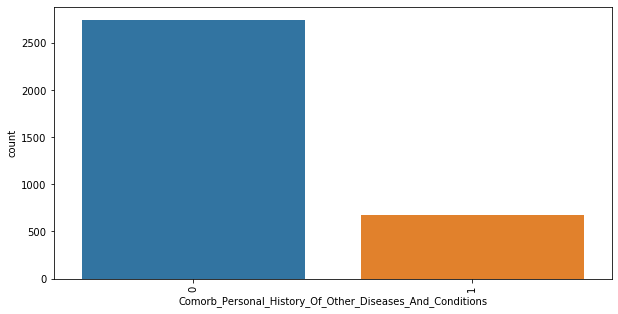

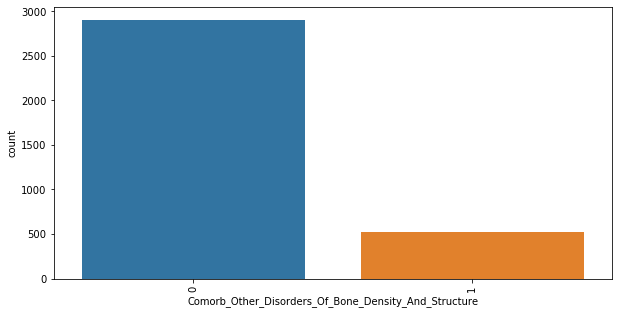

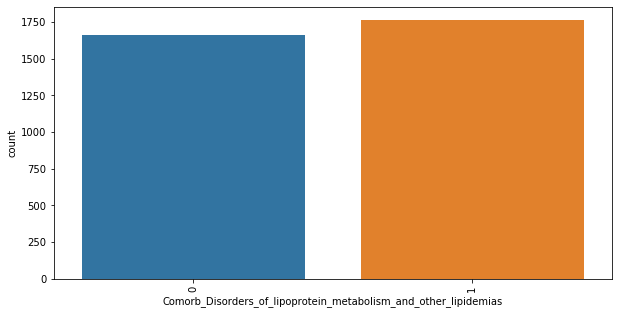

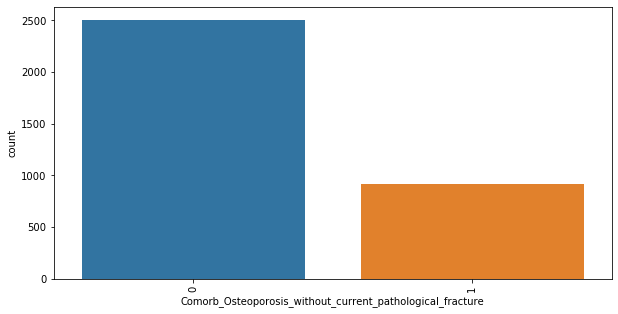

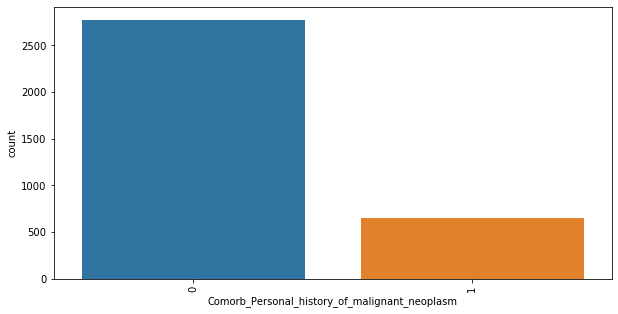

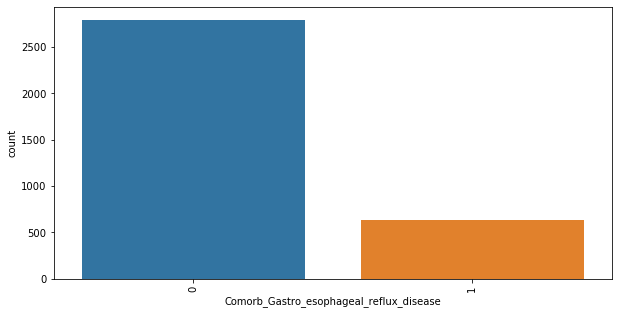

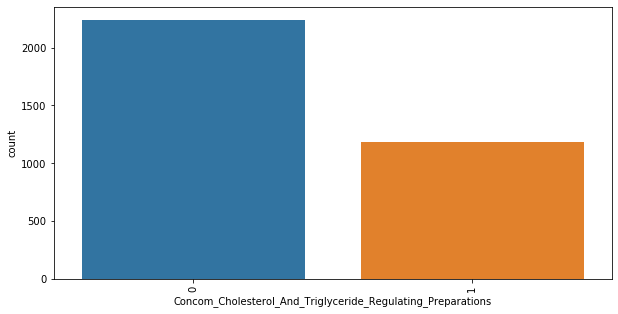

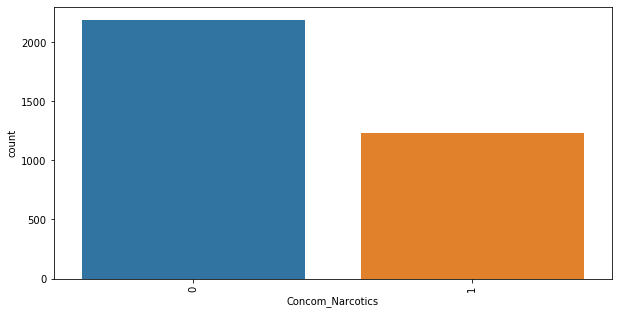

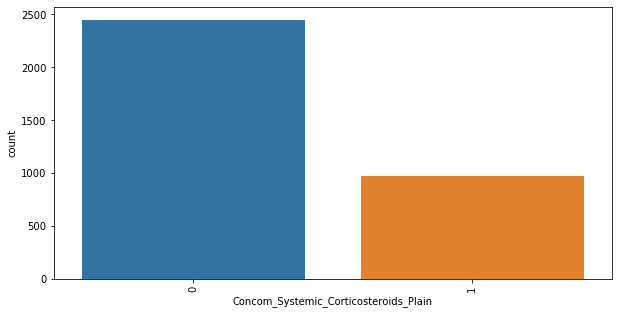

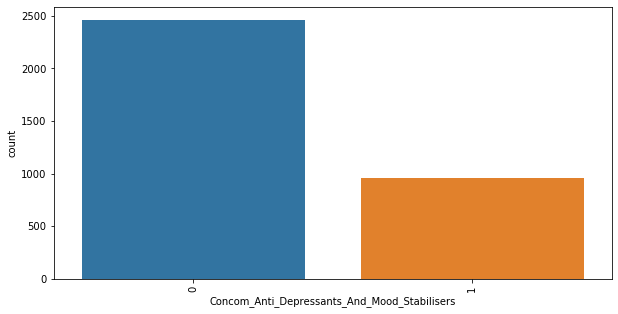

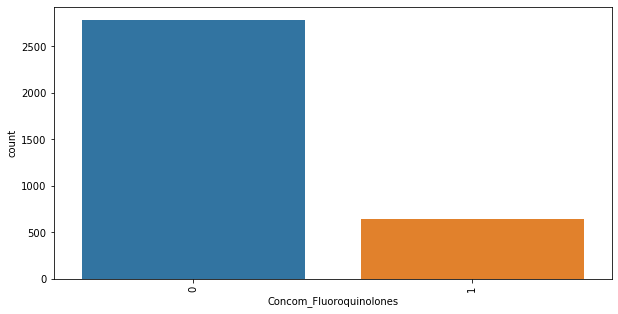

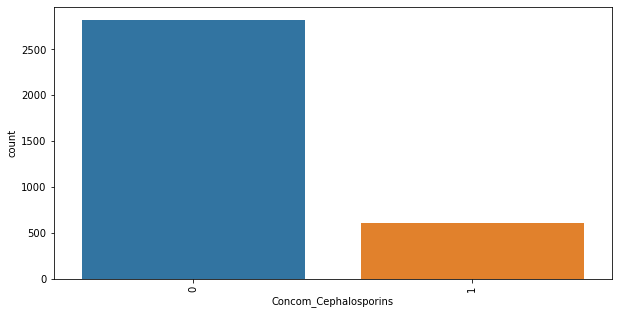

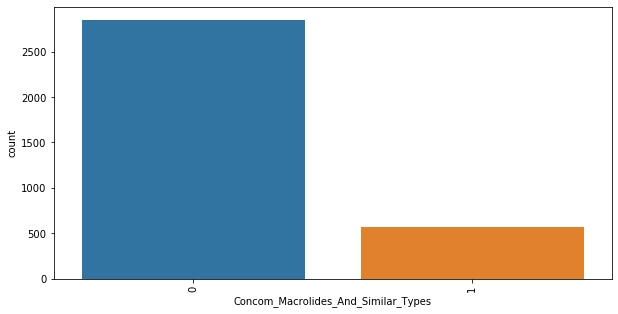

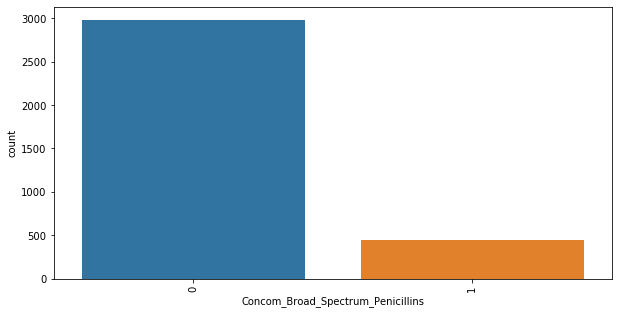

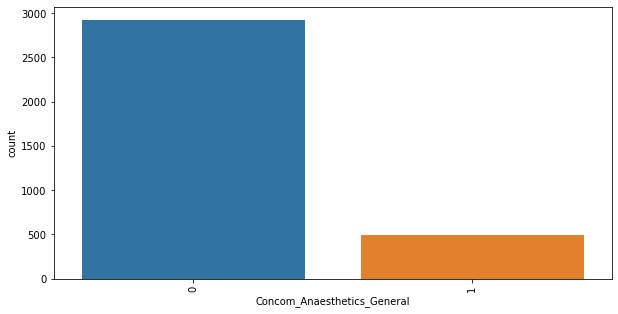

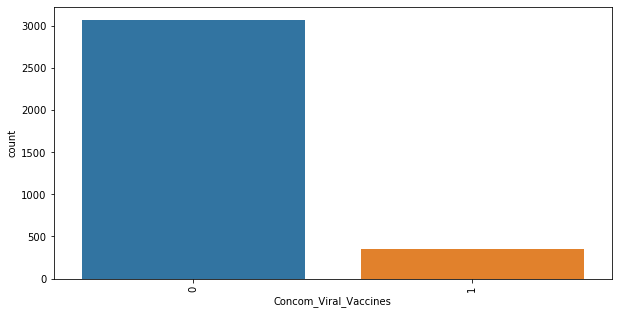

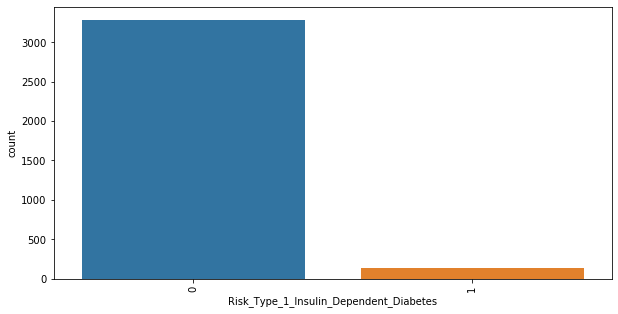

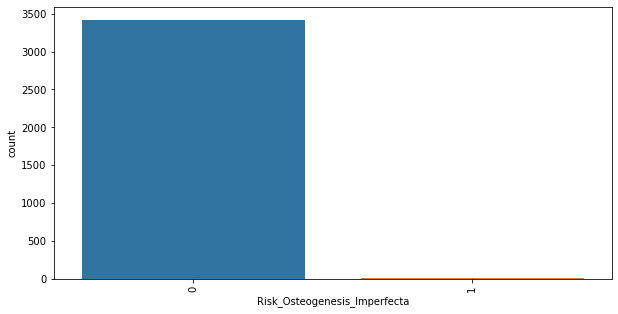

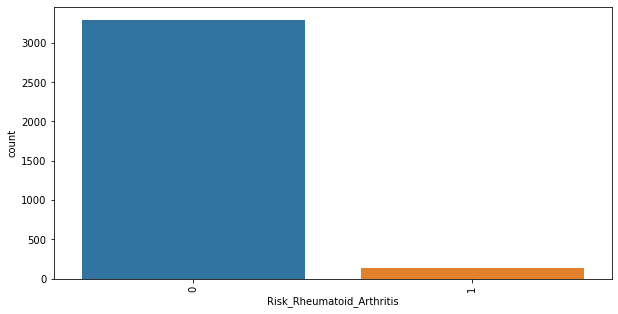

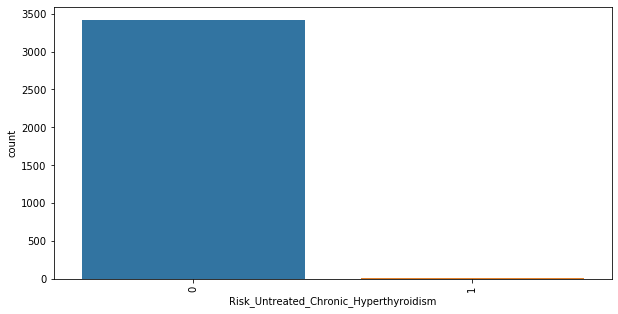

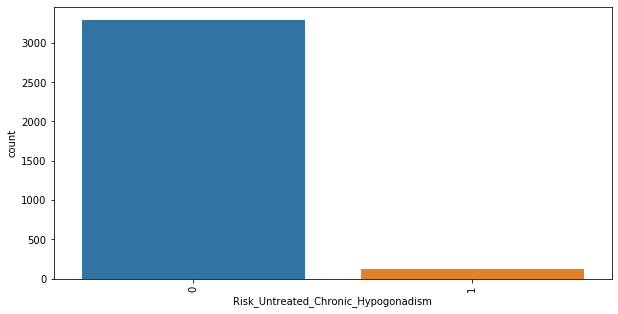

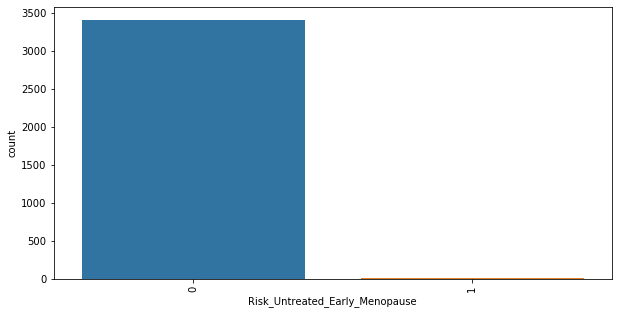

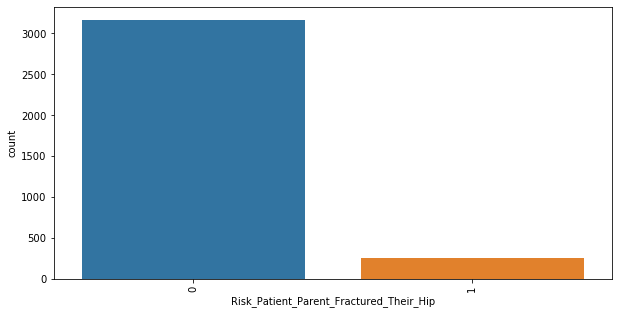

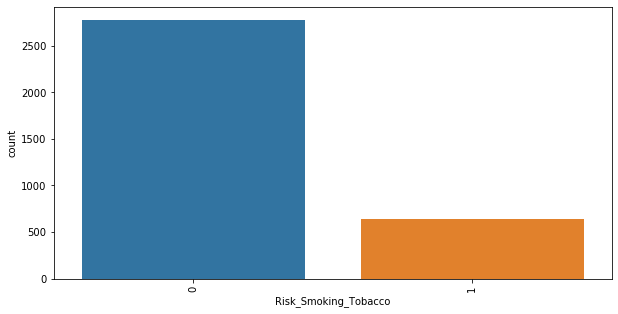

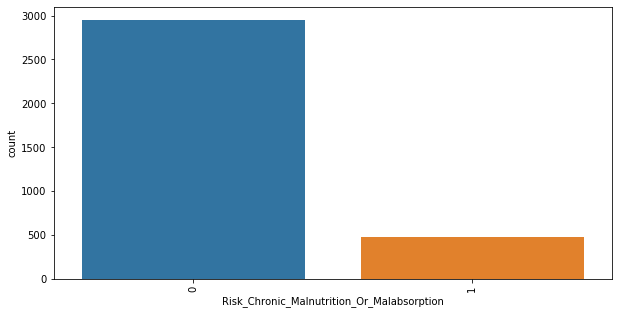

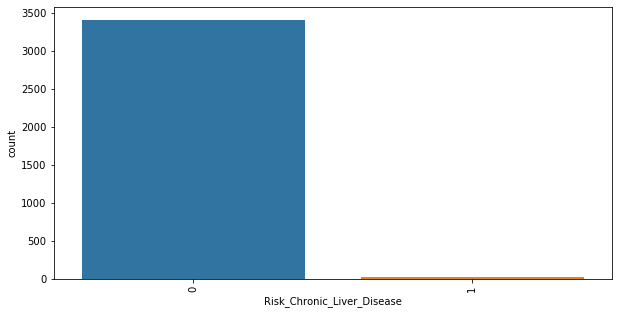

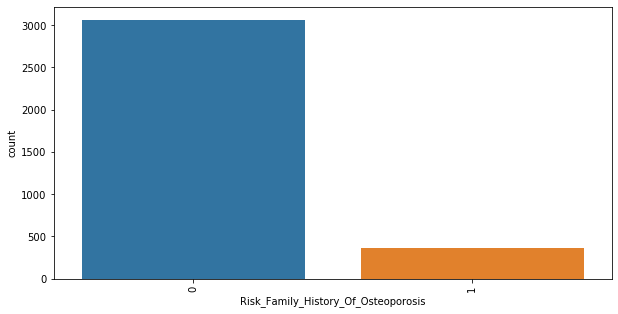

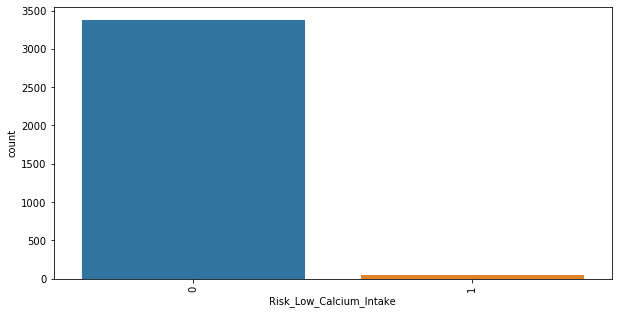

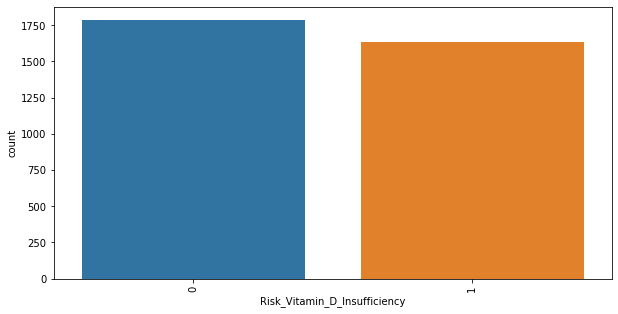

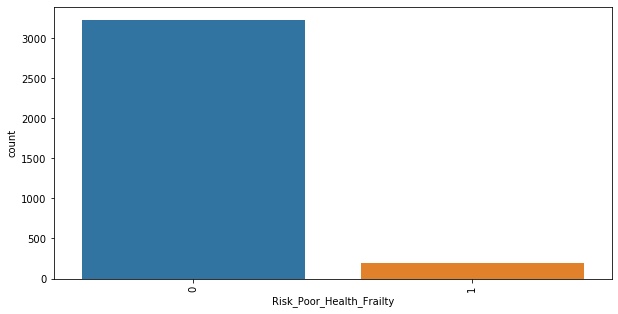

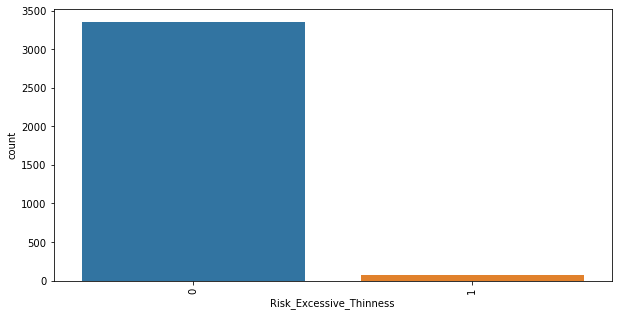

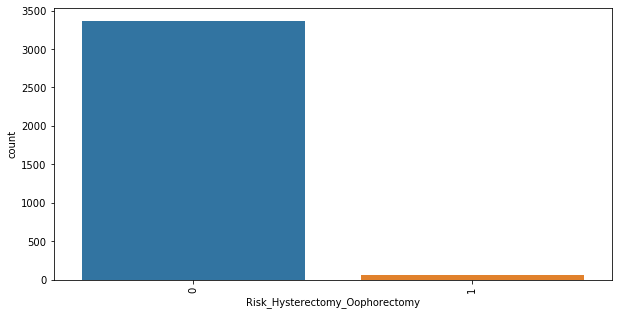

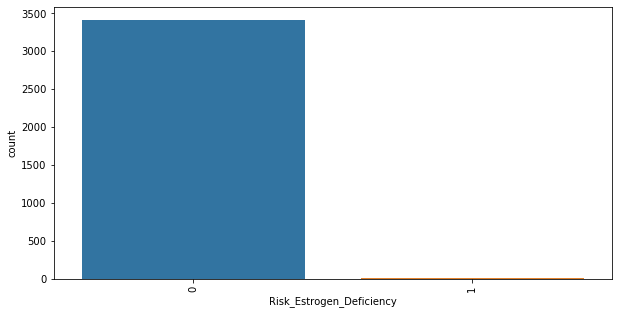

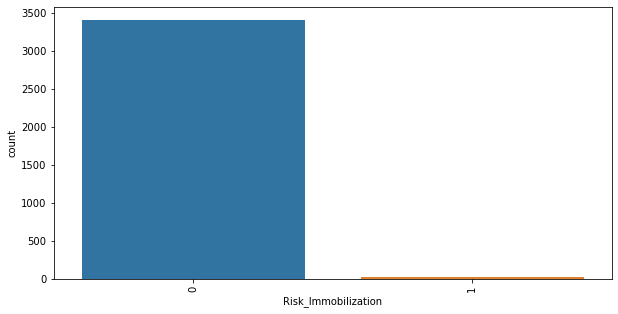

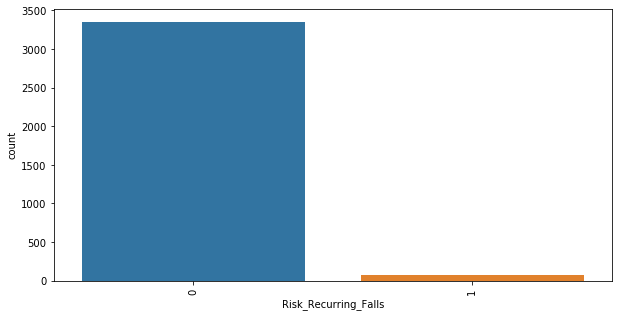

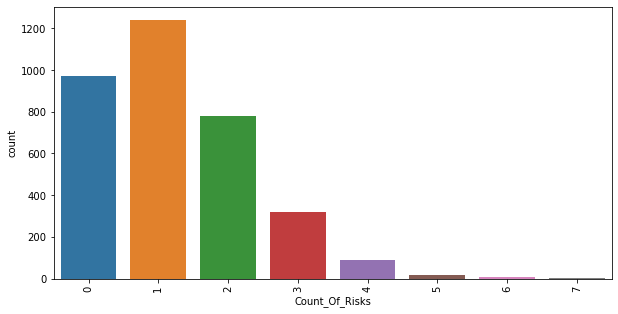

In [202]:
for column in ds.columns[1:]:
    plt.figure(figsize=(10, 5))
    sns.countplot(ds[column])
    plt.xticks(rotation=90)

From EDA we may say that:
    
    1.Patiens are mostly females, hypsanic race, coming from mildwest or south predominantly, having the age >55.
    
    2.Most of the patients are not persistent to the drugs.
    
    3.Change in Risk Segment is usually unknown or no change, very few worsened or even improved.
    
    4.There is usually at most 4 risks when taking the drugs. The risks usually are minimal either none, either 1 or 2.
    The risk that may appear concerns risk_smoking_tobacco, risk_malnutrition_or_malabsorption,risk_famili_hystory_of_osteoporosis and risk_vitamin_s_insufficiency.


By analysing the plots, we may say that:

Target classes are quite imbalanced.

The empty values are actualyy "Unknown" and sometimes met as "Other/Unknown" values.

Columns with outliers:

 - Gender : predominant females, the rest outliers
 - Race:  predominant Caucasian, the rest outliers
 - Ethnicity: predonimamnt Not hispanic, the rest outliers
 - Region: cathegory other outliers
 - Ntm_specialty : predonimant categories: general_preactitioner, unknoen, endocrinology, rheumatology, oncology, obstretics and gynecology; the rest outliers
 - Dexa_freq_during_rx : predominant : 0; the rest outliers
 - Adherent_flag: predominant adherent;  the rest outliers
 - Risk_Type_1_Insulin_Dependent_Diabetes: predominant False(0); True(1) outlier
 - Risk_Osteogenesis_Imperfecta: predominant False; True outlier
 - Risk_Rheumatoid_Arthritisitis: predominant False; True outlier
 - Risk_Untreated_Chronic_Hyperthyroidism: predominant False; True Outlier
 - Risk_Untreated_Chronic_Hypogonadism: predominant False; True Outlier
 - Risk_Untreated_Early_Menopause: predominant False; True Outlier
 - Risk_Patient_Parent_Fractured_Their_Hip: predominant False; True Outlier
 - Risk_Chronic_Liver_Disease: predominant False; True Outlier
 - Risk_Low_Calcium_Intake :predominant False; True Outlier
 - Risk_Poor_Health_Frailty: predominant False; True Outlier
 - Risk_Excessive_Thinness: predominant False; True Outlier
 - Risk_Hysterectomy_Oophorectomy: predominant False; True Outlier
 - Risk_Estrogen_Deficiency: predominant False; True Outlier
 - Risk_Immobilization : predominant False; True Outlier
 - Risk_Recurring_Falls: predominant False; True Outlier
 - Count_of_risks: 5,6,7 outliers


# NAN values

In [43]:
na_values = ['Unknown','Other/Unknown'] # add all values that should be converted to np.nan
ds = pd.read_excel('C:\\Users\\user\\Downloads\\git_v3\\HealthCare_project\\Healthcare_dataset.xlsx', 
                   'Dataset', index_col=None,na_values= na_values, keep_default_na = False)


In [44]:
def chec_nan_values(dataset):
    found = False
    list_column_nan = []
    for column in ds.columns:
        if ds[column].isnull().sum() != 0:
            found = True
            print('Column',column, 'has', ds[column].isnull().sum(),' null values')
            list_column_nan.append(column)
    if found  == False:
        print('The dataset does not contain empty values')
    return list_column_nan

In [45]:
list_column_nan = chec_nan_values(ds)

Column Race has 97  null values
Column Ethnicity has 91  null values
Column Region has 60  null values
Column Ntm_Speciality has 310  null values
Column Risk_Segment_During_Rx has 1497  null values
Column Tscore_Bucket_During_Rx has 1497  null values
Column Change_T_Score has 1497  null values
Column Change_Risk_Segment has 2229  null values


See plots how many NaN points are, related to other column categories.
![image info](./change_risk_Segment.png)
![image info](./change_t_score.png)
![image info](./ethnicity.png)
![image info](./ntm_specialty.png)
![image info](./risk_segment_during_rx.png)
![image info](./tscore_bucket_during_rx.png)

We may distinguish some cases:
    1. NaN values occurence is higher than the other column categories.
        Example 3 classes, NaN values occurence is the highest and the other 2 categories occurencies have almost
        similar dirtibution:
             - Relacing the NaN values with the category that has the highest ocuurence, we influence learning on
               only one category. 
             - We may replace half of NaN with one category and the other half with the other.
             - We may delete them 
             - We may predict them
    2. NaN values occurence is very lower than the other column categories. -> in this case it is suitable to 
       replace them with the category that has the highest occurence
    

# Predicting unknown values

Reading with unknown values original plot

In [46]:
ds = ds.replace(['N','Y'],[0,1])

In [47]:
list_columns_need_labelling = ['Persistency_Flag', 'Gender', 'Race','Ethnicity','Region','Age_Bucket','Ntm_Speciality','Ntm_Specialist_Flag','Ntm_Speciality_Bucket','Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag']

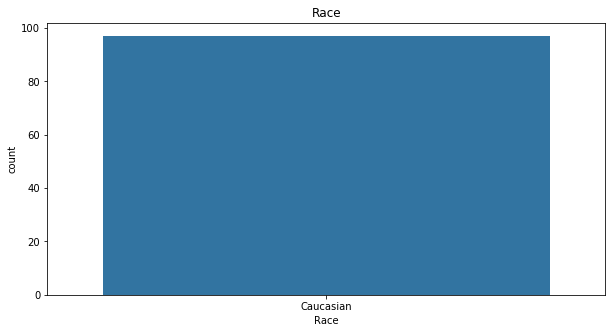

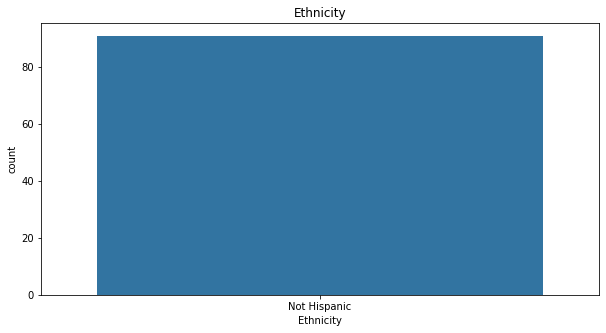

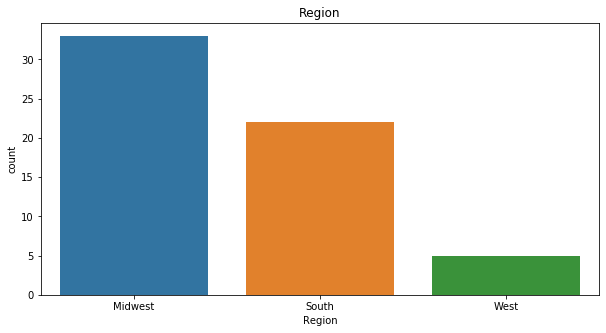

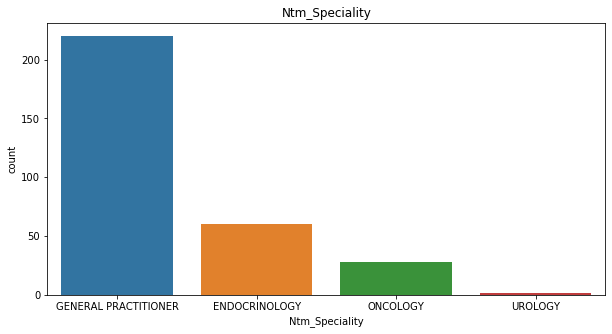

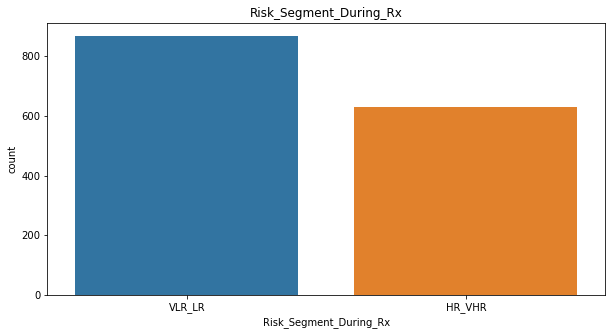

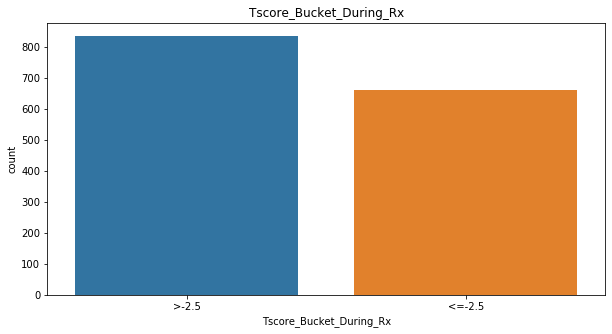

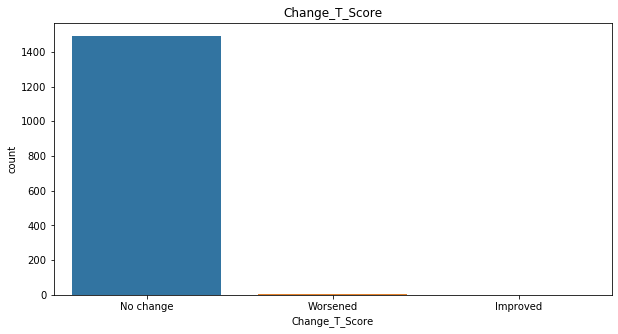

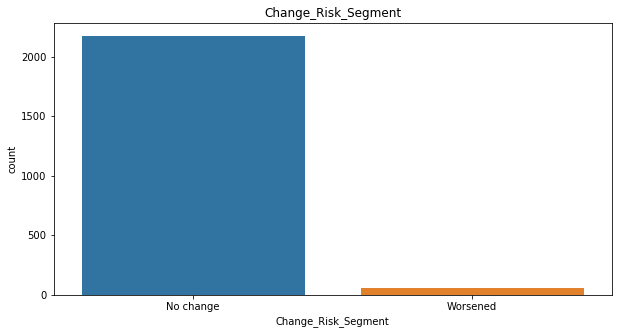

In [48]:
lr  = LogisticRegression(solver='newton-cg', random_state=0,class_weight=None)

for column_predict in list_column_nan:
    ds_copy = ds.copy()
    dict_labels = {}
    list_column_to_be_deleted = [i for i in list_column_nan if i!= column_predict ]
    ds_copy.drop( list_column_to_be_deleted, axis=1, inplace=True)
        
    X_train = ds_copy[ds_copy[column_predict].notnull()]    
    X_train.drop('Ptid', axis=1, inplace=True)
    X_test = ds_copy[pd.isnull(ds_copy[column_predict])]
    new_predicted_df = pd.DataFrame (X_test['Ptid'])
    X_test.drop('Ptid', axis=1, inplace=True)
    
    list_column_label = [x for x in list_columns_need_labelling if x not in list_column_to_be_deleted ]
    
    le = preprocessing.LabelEncoder()

    for column in list_column_label:
        new_column_name = "{}_labels".format(column)
        if column != column_predict:
            X_train[new_column_name] = le.fit_transform(X_train[[column]])
            X_test[new_column_name] = le.fit_transform(X_test[[column]])
        else:
            y_train = pd.DataFrame(le.fit_transform(X_train[[column]]))
        
            for k in range(len(le.classes_)):
                dict_labels[le.transform(le.classes_)[k]] =  le.classes_[k]

            
    X_train = X_train.select_dtypes(include= np.number)
    X_test =  X_test.select_dtypes(include= np.number)
        
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    
    new_predicted_df['{}'.format(column_predict)] = [dict_labels[j] for j in predictions]
    new_predicted_df.to_csv("predicted_{}_df.csv".format(column_predict), index = None)
    
   
    plt.figure(figsize=(10, 5))
    sns.countplot(new_predicted_df[column_predict])
    plt.title(column_predict)


# Merge predictions dataframe

In [49]:
for column_predict in list_column_nan:
    df = pd.read_csv("predicted_{}_df.csv".format(column_predict))
    ds.loc[pd.isnull(ds[column_predict]),[column_predict]]= df[column_predict].values

In [50]:
ds.shape

(3424, 69)

In [51]:
chec_nan_values(ds)

The dataset does not contain empty values


[]

In [52]:
columns_risks = []
columns_true = []
columns_false = []
for column in ds.columns: 
    if "Risk" in column and len(ds.value_counts(column).index) ==2 and ds.value_counts(column).index[0] == 0:
        columns_risks.append(column)
        columns_true.append(ds.value_counts(column)[1])
        columns_false.append(ds.value_counts(column)[0])
    elif  "Risk" in column: 
        print(ds.value_counts(column))

table = pd.DataFrame({'columns':columns_risks ,'True': columns_true, "False": columns_false})    
table

Risk_Segment_Prior_Ntm
VLR_LR    1931
HR_VHR    1493
dtype: int64
Risk_Segment_During_Rx
VLR_LR    1830
HR_VHR    1594
dtype: int64
Change_Risk_Segment
No change    3224
Worsened      178
Improved       22
dtype: int64
Count_Of_Risks
1    1242
0     970
2     781
3     317
4      91
5      15
6       6
7       2
dtype: int64


,columns,True,False
0,Risk_Type_1_Insulin_Dependent_Diabetes,139,3285
1,Risk_Osteogenesis_Imperfecta,3,3421
2,Risk_Rheumatoid_Arthritis,130,3294
3,Risk_Untreated_Chronic_Hyperthyroidism,2,3422
4,Risk_Untreated_Chronic_Hypogonadism,127,3297
5,Risk_Untreated_Early_Menopause,12,3412
6,Risk_Patient_Parent_Fractured_Their_Hip,256,3168
7,Risk_Smoking_Tobacco,644,2780
8,Risk_Chronic_Malnutrition_Or_Malabsorption,470,2954
9,Risk_Chronic_Liver_Disease,18,3406


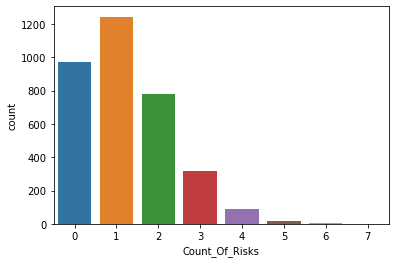

In [42]:
sns.countplot(ds['Count_Of_Risks'])

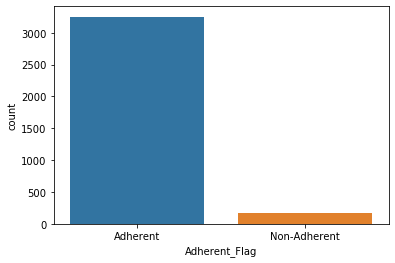

In [53]:
sns.countplot(ds['Adherent_Flag'])

In [54]:
ds.shape

(3424, 69)

In [55]:
ds.to_csv('no_Nan_outliers_yes.csv', index = False)

## Outliers

Why the outliers are a problem?

They do not contribute to model learning. The values are irrelevat and the model will only learn the dominant cathegories.
Large data slws down the training time, and for no reason.

- We can delete irrelevant data. 

- We can speed training by only trying dimensionality reduction algorithms whic will only learn using the most relevant data.


Step 1 : 

    -delete entirely the columns that 90% contain only one category value out of 2
    -from the rest of the columns delete rows that contain the outlier values
    

# Delete uncesessary columns

In [92]:
len(ds.columns)

69

In [93]:
list_columns_deleted = ['Ptid', 'Gender','Risk_Type_1_Insulin_Dependent_Diabetes','Risk_Osteogenesis_Imperfecta','Risk_Rheumatoid_Arthritis','Risk_Untreated_Chronic_Hyperthyroidism','Risk_Untreated_Chronic_Hypogonadism','Risk_Untreated_Early_Menopause','Risk_Patient_Parent_Fractured_Their_Hip','Risk_Chronic_Liver_Disease','Risk_Low_Calcium_Intake','Risk_Poor_Health_Frailty','Risk_Excessive_Thinness','Risk_Hysterectomy_Oophorectomy','Risk_Estrogen_Deficiency','Risk_Immobilization','Risk_Recurring_Falls']


In [94]:
ds.drop(list_columns_deleted, axis=1, inplace=True)

In [95]:
len(ds.columns)

52

# Label categorical columns as numerical values

In [97]:
list_columns_need_labelling = ['Persistency_Flag', 'Race','Ethnicity','Region','Age_Bucket','Ntm_Speciality','Ntm_Specialist_Flag','Ntm_Speciality_Bucket','Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag']

In [98]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

for column in list_columns_need_labelling:
    new_column_name = "{}_labels".format(column)
    ds[new_column_name] = ord_enc.fit_transform(ds[[column]])

In [99]:
len(ds.columns)

66

# Delete outliers

In [101]:
list_columns_contain_outliers = ['Race_labels','Ethnicity_labels','Region_labels', 'Ntm_Speciality_labels', 'Dexa_Freq_During_Rx', 'Adherent_Flag_labels']

In [102]:
ds.shape

(3424, 66)

In [103]:
for column in list_columns_contain_outliers:
    category_counts = ds.value_counts(column)
    values_category_counts = list(category_counts)                                          
    for element in range(len(values_category_counts)):
        if values_category_counts[element] < 100:
            ds.drop(ds.loc[ds[column]==category_counts.index[element]].index, inplace=True)

In [104]:
ds.shape

(2004, 66)

Save data including labeled columns but also original categories column with no Nan values and no outliers

Ready for EDA

In [106]:
ds.to_csv('cleaned_data.csv', index = False)

# Make a new dataframe with only numerical values that will be prepared for model training

In [107]:
process_df = ds.select_dtypes(include = np.number)

In [112]:
len(process_df.columns)

51

In [113]:
process_df.to_csv('data_training.csv', index = False)

In [5]:
data_training = pd.read_csv('training_data.csv')

In [6]:
data_training.columns

Index(['Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Idn_Indicator',
       'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
       'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
       'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
       'Comorb_Osteoporosis_without_current_pathological_fracture',
       'Comorb_Personal_history_of_malignant_neoplasm',
       'Comorb_Gastro_es

In [7]:
data_training.shape

(2004, 51)

In [8]:
X = data_training.drop('Persistency_Flag_labels', 1)
y = data_training['Persistency_Flag_labels']

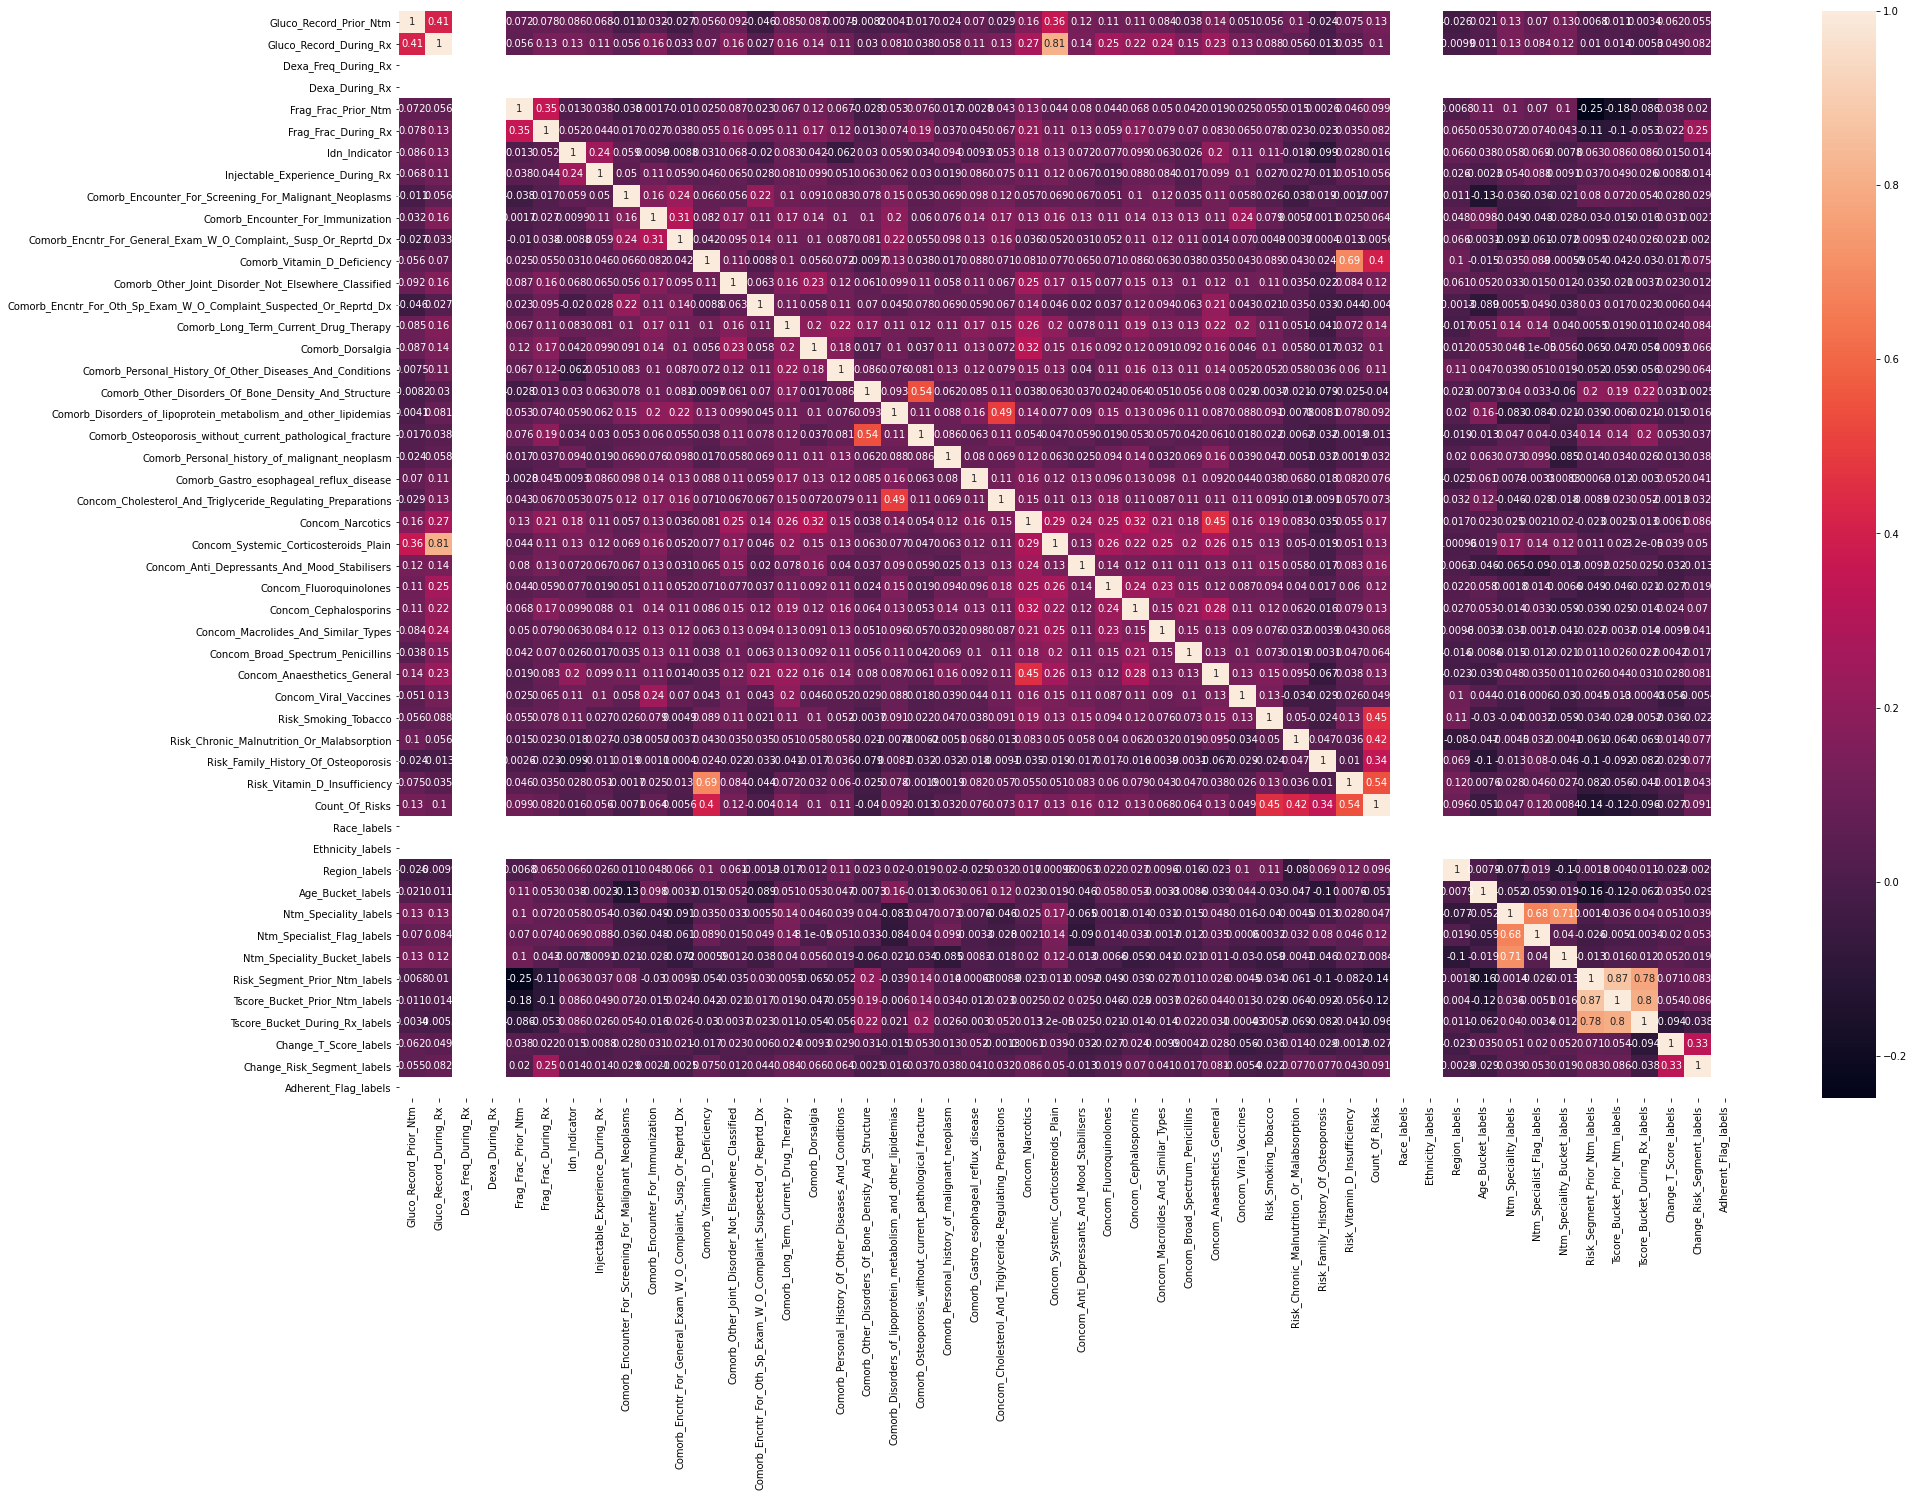

In [9]:
correlation_mat = X.corr()

fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(correlation_mat, annot = True)
plt.show()

<AxesSubplot:xlabel='Persistency_Flag_labels', ylabel='count'>

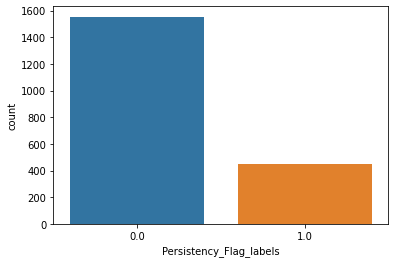

In [10]:
sns.countplot(y)

After deleting uncessary columns and outliers, the difference between target classes has become larger. We deal now with clearly imblanced data

Train with data as it is

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [12]:
X_train.shape

(1603, 50)

In [13]:
X_test.shape

(401, 50)

<AxesSubplot:xlabel='Persistency_Flag_labels', ylabel='count'>

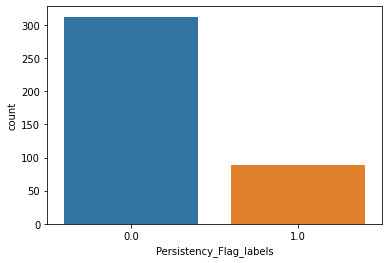

In [19]:
sns.countplot(y_test)

In [14]:
from sklearn import svm 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

C_param = 1 
svm_model = svm.SVC(C_param, "linear", gamma= 'auto',probability= True) 
svm_model.fit(X_train, y_train) 
 

SVC(C=1, gamma='auto', kernel='linear', probability=True)

In [15]:
predicted_labels_test = svm_model.predict(X_test)

In [16]:
confusion_matrix(y_test, predicted_labels_test)

array([[301,  11],
       [ 53,  36]], dtype=int64)

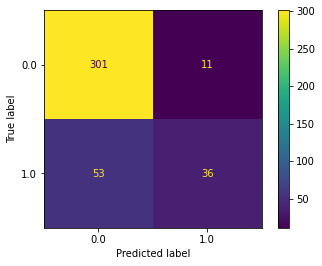

In [17]:
plot_confusion_matrix(svm_model, X_test, y_test)  
plt.show()

In [18]:
print('Classification report')
print(classification_report(y_test,predicted_labels_test))

Classification report
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       312
         1.0       0.77      0.40      0.53        89

    accuracy                           0.84       401
   macro avg       0.81      0.68      0.72       401
weighted avg       0.83      0.84      0.82       401



 - Precision gives the percentage of the correct prediction from all values predicted positive.
    P= TP/(TP+FP)
 - Recall measure the percentage of the correct prediction from all values that were actually positive. 
    R= TP/(TP+FN)
 - F1 score weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.
     F1 score= 2*(R*P)/(R+P)
 - Support is the number of actual occurrences of the class in the specified dataset.

In [131]:
svm_model.predict_proba(X_test)


array([[0.65927916, 0.34072084],
       [0.75691634, 0.24308366],
       [0.83834877, 0.16165123],
       [0.89071444, 0.10928556],
       [0.84644283, 0.15355717],
       [0.96349874, 0.03650126],
       [0.8923102 , 0.1076898 ],
       [0.92866869, 0.07133131],
       [0.79387641, 0.20612359],
       [0.45453993, 0.54546007],
       [0.82245587, 0.17754413],
       [0.84934314, 0.15065686],
       [0.40445579, 0.59554421],
       [0.55509455, 0.44490545],
       [0.91141887, 0.08858113],
       [0.76299938, 0.23700062],
       [0.39530672, 0.60469328],
       [0.33274014, 0.66725986],
       [0.91327687, 0.08672313],
       [0.83025271, 0.16974729],
       [0.93193306, 0.06806694],
       [0.72383837, 0.27616163],
       [0.92552282, 0.07447718],
       [0.83941366, 0.16058634],
       [0.94239776, 0.05760224],
       [0.10262463, 0.89737537],
       [0.91870958, 0.08129042],
       [0.9289189 , 0.0710811 ],
       [0.92784937, 0.07215063],
       [0.96554083, 0.03445917],
       [0.

[0.17989728, 0.82010272] -> clearly the second class

[0.96589305, 0.03410695] -> clearlt the first class

The Probability is not random one. Considering the imbalacing condition, this is a very good result.

In [25]:
print('ROC AUC score on test data', roc_auc_score(y_test,svm_model.predict_proba(X_test)[:, 1] ))

print('ROC AUC score on the entire dataset', roc_auc_score(y, svm_model.decision_function(X)))

ROC AUC score on test data 0.8340535868625757
ROC AUC score on the entire dataset 0.838195338195338


Apply PCA dimensionality reduction and train again

Apply PCA on the whole dataset

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=50)
pca.fit(X)
X_pca = pca.transform(X)

Show what number of components has the best variance

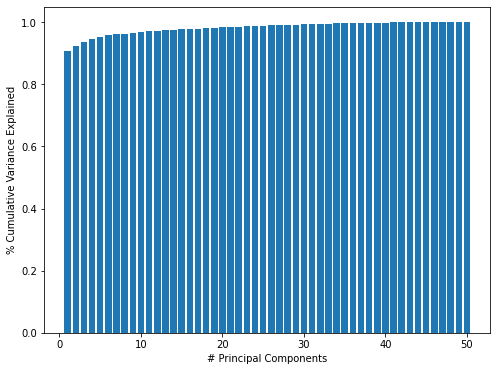

In [27]:
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,51), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

From this graph we can see that the variance is improving with the number of fetures. The best variance is reahed when having all features. The dimensonality reduction is not suitable in this case.

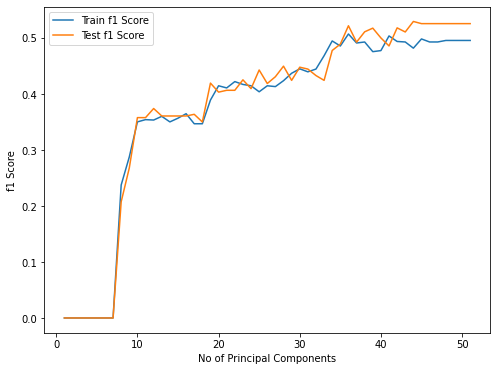

In [28]:
from sklearn.metrics import f1_score

train_f1 = []
test_f1 = []

C_param = 1 
svm_model = svm.SVC(C_param, "linear", probability= True)

for i in range(51):
    
    X = X_pca[:,0:i+1]
    
    #split dataset on which we have applied PCA
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=30)
    #normalise features
    sc = StandardScaler()
    X_train_pca = sc.fit_transform(X_train_pca)
    X_test_pca = sc.transform(X_test_pca)

    svm_model.fit(X_train_pca, y_train_pca) 

    y_pred_train = svm_model.predict(X_train_pca)
    y_pred_test = svm_model.predict(X_test_pca)
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

# Plot accuracy by n_neighbors
plt.figure(figsize=(8, 6))
plt.plot(range(1,52), train_f1, label='Train f1 Score')
plt.plot(range(1,52), test_f1, label='Test f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('No of Principal Components')
plt.legend()
plt.show()

The best F1 score is reached with all 50 features. We need all features to get a good result. 

In [29]:
#see that with fewest features, the results are worsen (change number of feture taken from X_pca)
X = X_pca[:,0:52]

   
#split dataset on which we have applied PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=30)
#normalise features
sc = StandardScaler()
X_train_pca = sc.fit_transform(X_train_pca)
X_test_pca = sc.transform(X_test_pca)

svm_model.fit(X_train_pca, y_train_pca) 

y_pred_train = svm_model.predict(X_train_pca)
y_pred_test = svm_model.predict(X_test_pca)
    
print(f'Train f1 Score: {f1_score(y_train_pca, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test_pca, y_pred_test)}')
print(classification_report(y_test_pca, y_pred_test))

Train f1 Score: 0.4955116696588868
Test f1 Score: 0.5255474452554744
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       312
         1.0       0.75      0.40      0.53        89

    accuracy                           0.84       401
   macro avg       0.80      0.68      0.71       401
weighted avg       0.83      0.84      0.82       401



In [30]:
import pickle
filename = 'svm_model.pkl'
pickle.dump(svm_model, open(filename, 'wb'))

In [133]:
confusion_matrix(y_test_pca, y_pred_test)

array([[300,  12],
       [ 53,  36]], dtype=int64)

In [134]:
print('ROC AUC score on test data', roc_auc_score(y_test_pca,svm_model.predict_proba(X_test_pca)[:, 1] ))

print('ROC AUC score on the entire dataset', roc_auc_score(y, svm_model.decision_function(X)))

ROC AUC score on test data 0.8343056755978105
ROC AUC score on the entire dataset 0.8144144144144143


Upsampling

In [135]:
data_training = pd.read_csv('data_training.csv')

In [136]:
data_training['Persistency_Flag_labels'].value_counts()

0.0    1554
1.0     450
Name: Persistency_Flag_labels, dtype: int64

In [137]:
from sklearn.utils import resample

data_when_false = data_training[data_training['Persistency_Flag_labels']==0]
data_when_true = data_training[data_training['Persistency_Flag_labels']==1]

data_when_false_upsampled = resample(data_when_true,
                          replace=True, 
                          n_samples=len(data_when_false), 
                          random_state=27)

upsampled = pd.concat([data_when_false, data_when_false_upsampled])

upsampled['Persistency_Flag_labels'].value_counts()

0.0    1554
1.0    1554
Name: Persistency_Flag_labels, dtype: int64

In [138]:
X = upsampled.drop('Persistency_Flag_labels', 1)
y = upsampled['Persistency_Flag_labels']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [140]:
X_train.shape

(2486, 50)

In [141]:
X_test.shape

(622, 50)

In [142]:
C_param = 1 
svm_model = svm.SVC(C_param, "linear", probability= True) 
svm_model.fit(X_train, y_train) 

SVC(C=1, kernel='linear', probability=True)

In [143]:
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.7771850636027903
Test f1 Score: 0.7819314641744548
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.77       307
         1.0       0.77      0.80      0.78       315

    accuracy                           0.77       622
   macro avg       0.78      0.77      0.77       622
weighted avg       0.78      0.77      0.77       622



In [144]:
confusion_matrix(y_test, y_pred_test)

array([[231,  76],
       [ 64, 251]], dtype=int64)

In [145]:
print('ROC AUC score on test data', roc_auc_score(y_test,svm_model.predict_proba(X_test)[:, 1] ))

print('ROC AUC score on the entire dataset', roc_auc_score(y, svm_model.decision_function(X)))

ROC AUC score on test data 0.8349154645571584
ROC AUC score on the entire dataset 0.8453093192475432


The accuracy is even lower. By upsampling the true classes is not a solution to improvement.

Downsampling

In [146]:
data_when_false_downsampled = resample(data_when_false,
                          replace=True, 
                          n_samples=len(data_when_true), 
                          random_state=27)

downsampled = pd.concat([data_when_true, data_when_false_downsampled])

downsampled['Persistency_Flag_labels'].value_counts()

0.0    450
1.0    450
Name: Persistency_Flag_labels, dtype: int64

In [147]:
X = downsampled.drop('Persistency_Flag_labels', 1)
y = downsampled['Persistency_Flag_labels']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [149]:
X_train.shape

(720, 50)

In [150]:
X_test.shape

(180, 50)

In [151]:
C_param = 1 
svm_model = svm.SVC(C_param, "linear", probability= True) 
svm_model.fit(X_train, y_train) 

SVC(C=1, kernel='linear', probability=True)

In [152]:
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.7513812154696132
Test f1 Score: 0.7764705882352941
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80        96
         1.0       0.77      0.79      0.78        84

    accuracy                           0.79       180
   macro avg       0.79      0.79      0.79       180
weighted avg       0.79      0.79      0.79       180



In [153]:
confusion_matrix(y_test, y_pred_test)

array([[76, 20],
       [18, 66]], dtype=int64)

In [154]:
print('ROC AUC score on test data', roc_auc_score(y_test,svm_model.predict_proba(X_test)[:, 1] ))

print('ROC AUC score on the entire dataset', roc_auc_score(y, svm_model.decision_function(X)))

ROC AUC score on test data 0.8550347222222221
ROC AUC score on the entire dataset 0.8365382716049383


The results are even worst.

Conclusions

 - In terms of accuracy, removing outliers does not influence so much model training, but it definitely speeds it up, especially if we are dealing with large datasets.
 
 - 50 features is the ideal number in order to get best results using SVM classifier.

 - There is no need for dimensionality reductin as smaller fetures lead to worsen results.

 - Altough the target classes are imbalanced, by applying upsampling and downsampling in order to reprodiuce the same number of target classes data, the results are getting worst.